In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy
import sys
import pdb
import matplotlib.pyplot as plt
from glob import glob
import pickle
from pyuoi.linear_model.var import VAR
from tqdm import tqdm
import pandas as pd
from neurosim.models.var import VAR as VARss
from neurosim.models.var import form_companion
from copy import deepcopy
from sklearn.model_selection import KFold

In [3]:
sys.path.append('../..')
from loaders import load_sabes, load_peanut, load_cv
from subspaces import estimate_autocorrelation
from utils import apply_df_filters
from dstableFGM import dstable_descent

#### plots to include for 4/6:
#### (1) Pseudospectra/Polar Decomposition, (2) CV selection (joint vs marginal when applicable), (3) LQGCA subspace angles

### Pseudospectral Calculation

In [5]:
from pseudopy import NonnormalAuto, Normal

In [6]:
# Consolidate
indy_fits = glob('/mnt/Secondary/data/indy_cv_var/indy_cv_var_*.dat')
rl = []
for file_ in indy_fits:
    with open(file_, 'rb') as f:
        args = pickle.load(f)
        coef = pickle.load(f)
    rd = {}
    for key, value in args.items():
        if type(value) == dict:
            for key_, value_ in value.items():
                rd[key_] = value_
        else:
            rd[key] = value
    
    rd['coef'] = coef
    rl.append(rd)
indy_df = pd.DataFrame(rl)

In [7]:
with open('/home/akumar/nse/neural_control/data/indy_var_df.dat', 'wb') as f:
    f.write(pickle.dumps(rl))

In [111]:
with open('loco_df.dat', 'rb') as f:
    rl = pickle.load(f)
loco_df = pd.DataFrame(rl)

In [5]:
with open('cv_result_list.dat', 'rb') as f:
    cv_result_list = pickle.load(f)
cv_df = pd.DataFrame(cv_result_list)

In [6]:
data_file = '/mnt/Secondary/data/peanut/data_dict_peanut_day14.obj'
loader_args = {'bin_width':25, 'epoch': 4, 'filter_fn':'none', 'filter_kwargs':{}, 'boxcox':0.5, 'spike_threshold':100}
dat = load_peanut(data_file, **loader_args, region='HPc')
y = np.squeeze(dat['spike_rates'])
varmodel = VAR(estimator='ols', order=2)
varmodel.fit(y)
A_HPc = form_companion(varmodel.coef_)

loader_args = {'bin_width':25, 'epoch': 4, 'filter_fn':'none', 'filter_kwargs':{}, 'boxcox':0.5, 'spike_threshold':100}
dat = load_peanut(data_file, **loader_args, region='OFC')
y = np.squeeze(dat['spike_rates'])
varmodel = VAR(estimator='ols', order=2)
varmodel.fit(y)
A_OFC = form_companion(varmodel.coef_)

Rows of VAR matrix processed: 54it [00:00, 66.60it/s]
Rows of VAR matrix processed: 208it [00:17, 11.61it/s]


In [11]:
data_files = np.unique(indy_df['data_file'].values)

In [12]:
df_ = apply_df_filters(indy_df, data_file=data_files[0], fold_idx = 2, order=3)
A_M1 = form_companion(df_.iloc[0]['coef'])

# df_ = apply_df_filters(loco_df, fold_idx=0, order=2, region='S1', self_regress=False)
# A_S1 = form_companion(df_.iloc[0]['coef'])

# df_ = apply_df_filters(cv_df, fold_idx =0, var_order=2)
# A_CV = form_companion(df_.iloc[0]['coef'])


In [11]:
A_cv_proj = dstable_descent(A_CV, maxiter=int(2e3))

8.25882926169368
4.762192198744381
4.039985084130226
2.7075717426418398
2.4939995802621873
2.320927718029961
2.2175865490845452
2.1153817074807946
1.9331452652958792
1.888987285568386
1.783692943088448
1.7192372048886453
1.718591109625115
1.6387231608422514
1.6265752679467775
1.591149125198185
1.5780611747045767
1.5188574996927402
1.5179393733376467
1.4962717722564884
1.4526035868545726
1.4387678468273446
1.4244208718020994
1.4048481498914855
1.38254414504344
1.3722387935956313
1.3630270160040645
1.3506856823089042
1.3331540300995792
1.3306332645205612
1.307017018123918
1.306705620004656
1.294575233141694
1.2789521231454049
1.273842563393043
1.268892451412364
1.2582874983634156
1.2459303094566279
1.2420950398542046
1.2387623019559355
1.2301138027252836
1.2191791773646128
1.2175550221736853
1.216789977852478
1.20937933534775
1.198553130656674
1.187024304002489
1.1819252053695208
1.1759713926041522
1.1746491055501866
1.1650127585382766
1.1603768584629
1.1552005156056897
1.153079769689924

In [12]:
np.linalg.norm(A_cv_proj - A_CV)

0.9981807941746584

In [ ]:
# Project the A_CV onto stable matrix

In [22]:
nn_M1 = NonnormalAuto(A_M1, 1e-5, 1)

In [23]:
nn_HPc = NonnormalAuto(A_HPc, 1e-5, 1)

In [13]:
nn_CV = NonnormalAuto(A_cv_proj, 1e-3, 1e-1)

In [25]:
nn_S1 = NonnormalAuto(A_S1, 1e-5, 1)

In [19]:
nn_OFC = NonnormalAuto(A_OFC, 1e-5, 1)

KeyboardInterrupt: 

In [9]:
# with open('pseudospectral_calculations.dat', 'wb') as f:
#     f.write(pickle.dumps(nn_M1))
#     f.write(pickle.dumps(nn_HPc))
#     f.write(pickle.dumps(nn_CV))
#     f.write(pickle.dumps(nn_S1))
#    f.write(pickle.dumps(nn_OFC))
# with open('pseudospectral_calculations_projected.dat', 'wb') as f:
#     f.write(pickle.dumps(nn_CV))

# with open('pseudospectral_calculations_projected.dat', 'rb') as f:
#     nn_CV = pickle.load(f)

with open('pseudospectral_calculations.dat', 'rb') as f:
    nn_M1 = pickle.load(f)
    nn_HPc = pickle.load(f)
    nn_CV = pickle.load(f)
#     #nn_S1 = pickle.load(f)
# #     nn_OFC = pickle.load(f)

In [13]:
n_M1 = Normal(A_M1)
# n_HPc = Normal(A_HPc)
# n_CV = Normal(A_cv_proj)
# n_S1 = Normal(A_S1)
# n_OFC = Normal(A_OFC)

In [4]:
import matplotlib as mpl
from matplotlib import cm

In [15]:
class MplColorHelper:

  def __init__(self, cmap_name, start_val, stop_val):
    self.cmap_name = cmap_name
    self.cmap = plt.get_cmap(cmap_name)
    self.norm = mpl.colors.Normalize(vmin=start_val, vmax=stop_val)
    self.scalarMap = cm.ScalarMappable(norm=self.norm, cmap=self.cmap)

  def get_rgb(self, val):
    return self.scalarMap.to_rgba(val)

In [16]:
levels = [1e-5, 1e-4, 0.001, 0.01, 0.1, 1]

In [17]:
# Plot first the eigenvalues, and then around there, for contoursfor 1e-1 for non normal and normal spectra
# Then, plot the distribution of condition numbers as a function of eigenvalue magnitude

In [18]:
import logging

In [20]:
logging.getLogger('matplotlib.font_manager').disabled = True

In [5]:
with open('/mnt/Secondary/data/postprocessed/indy_decoding_df2.dat', 'rb') as f:
    indy_df = pickle.load(f)
indy_df = pd.DataFrame(indy_df)    

/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LinearRegression from version 0.24.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [6]:
with open('/mnt/Secondary/data/postprocessed/loco_decoding_df.dat', 'rb') as f:
    loco_df = pickle.load(f)
loco_df = pd.DataFrame(loco_df)
loco_df = apply_df_filters(loco_df,
                        loader_args={'bin_width': 50, 'filter_fn': 'none', 'filter_kwargs': {}, 'boxcox': 0.5, 'spike_threshold': 100, 'region': 'M1'},
                        decoder_args={'trainlag': 4, 'testlag': 4, 'decoding_window': 5})
good_loco_files = ['loco_20170210_03.mat',
 'loco_20170213_02.mat',
 'loco_20170215_02.mat',
 'loco_20170227_04.mat',
 'loco_20170228_02.mat',
 'loco_20170301_05.mat',
 'loco_20170302_02.mat']

loco_df = apply_df_filters(loco_df, data_file=good_loco_files)

/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LinearRegression from version 0.24.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [7]:
dim = 6
indy_data_files = np.unique(indy_df['data_file'].values)
loco_data_files = np.unique(loco_df['data_file'].values)
ss_angles = np.zeros((len(indy_data_files) + len(loco_data_files), 5, dim))
folds = np.arange(5)
dimreduc_methods = dimreduc_methods = ['PCA', 'LQGCAtrace']
dimvals = np.unique(indy_df['dim'].values)

# Pick one
decoder_arg = indy_df.iloc[0]['decoder_args']
df = apply_df_filters(indy_df, decoder_args=decoder_arg)
for i, data_file in enumerate(indy_data_files):
    for f, fold in enumerate(folds):

        dfpca = apply_df_filters(df, data_file=data_file, dimreduc_method='PCA', fold_idx=fold, dim=dim)
        dffcca = apply_df_filters(df, data_file=data_file, dimreduc_method='LQGCA', fold_idx=fold, dim=dim)

        assert(dfpca.shape[0] == 1)
        assert(dffcca.shape[0] == 1)
        
        ss_angles[i, f, :] = scipy.linalg.subspace_angles(dfpca.iloc[0]['coef'][:, 0:dim], dffcca.iloc[0]['coef'])

for i, data_file in enumerate(loco_data_files):
    for f, fold in enumerate(folds):
        dfpca = apply_df_filters(loco_df, data_file=data_file, dimreduc_method='PCA', fold_idx=fold, dim=dim)
        dffcca = apply_df_filters(loco_df, data_file=data_file, dimreduc_method='LQGCA', fold_idx=fold, dim=dim)

        assert(dfpca.shape[0] == 1)
        assert(dffcca.shape[0] == 1)
        
        ss_angles[i + len(indy_data_files), f, :] = scipy.linalg.subspace_angles(dfpca.iloc[0]['coef'][:, 0:dim], dffcca.iloc[0]['coef'])


/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/pseudopy/normal.py:38: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  pseudospec = cascaded_union(circles)
/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/pseudopy/utils.py:40: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in obj:


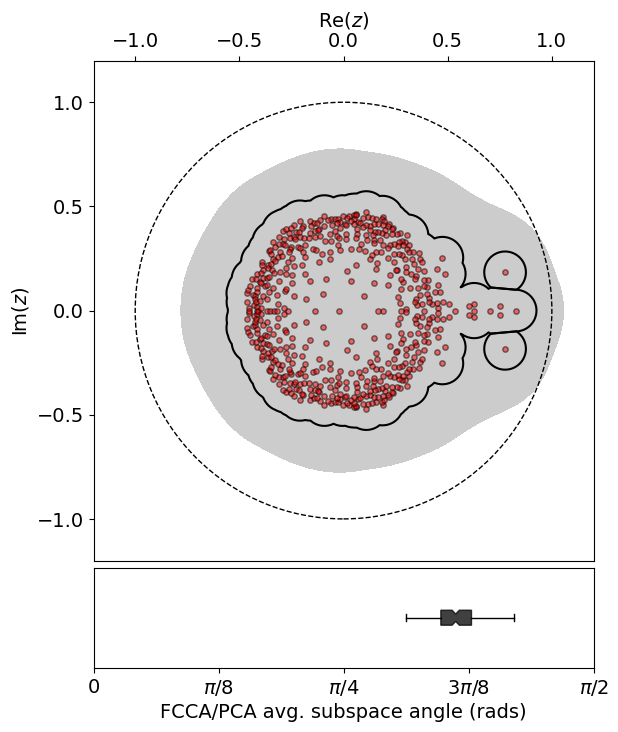

In [28]:
#fig, ax = plt.subplots(2, 1, figsize=(5, 5))
fig = plt.figure(figsize=(5, 6))
rect1 = [0, 1./6., 1, 6./7.]
rect2 = [0, 0, 1, 1./6.]

levels = [1e-6, 1e-1]

ax = fig.add_axes(rect1)

ax.set_aspect('equal')
ax.tricontourf(nn_M1.triang, nn_M1.vals, levels=levels, colors=['k'], alpha=0.2)
ax.scatter(np.real(np.linalg.eigvals(A_M1)), np.imag(np.linalg.eigvals(A_M1)), s=15, alpha=0.5, marker='o', edgecolor='k', color='r')

epsilons = list(np.sort(levels))
padepsilons = [epsilons[0]*0.9] + epsilons + [epsilons[-1]*1.1]
X = []
Y = []
Z = []
for epsilon in padepsilons:
    paths = n_M1.contour_paths(epsilon)
    for path in paths:
        X += list(np.real(path.vertices[:-1]))
        Y += list(np.imag(path.vertices[:-1]))
        Z += [epsilon] * (len(path.vertices) - 1)
ax.tricontour(X, Y, Z, levels=[1e-1], colors='k')


# Add stability circle
circle1 = plt.Circle((0, 0), 1, color='k', fill=False, linestyle='--')
ax.add_patch(circle1)
ax.set_ylabel('Im' + r'$(z)$', fontsize=14)
ax.set_yticks([-1., -0.5, 0, 0.5, 1.])
ax.set_xlabel('Re' + r'$(z)$', fontsize=14)
ax.set_xticks([-1., -0.5, 0, 0.5, 1.])

ax.set_xlim([-1.2, 1.2])
ax.set_ylim([-1.2, 1.2])
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')

ax.tick_params(axis='both', labelsize=14)

ax_hist = fig.add_axes(rect2)
medianprops = {'linewidth':0}
bplot = ax_hist.boxplot(np.mean(ss_angles, axis=-1).ravel(), patch_artist=True, medianprops=medianprops, notch=True, vert=False, showfliers=False)

# ax_hist.hist(np.mean(ss_angles, axis=-1).ravel(), color='r', alpha=0.5, linewidth=1, edgecolor='k')
# ax_hist.set_xlim([0, np.pi/2])
# ax_hist.tick_params(axis='both', labelsize=14)
# ax_hist.set_ylabel('Count', fontsize=14)
ax_hist.set_yticks([])
ax_hist.set_xlabel('FCCA/PCA avg. subspace angle (rads)', fontsize=14)
ax_hist.set_xticks([0, np.pi/8, np.pi/4, 3 * np.pi/8, np.pi/2])
ax_hist.set_xticklabels(['0', r'$\pi/8$', r'$\pi/4$', r'$3\pi/8$', r'$\pi/2$'], fontsize=14)

for patch in bplot['boxes']:
    patch.set_facecolor('k')
    patch.set_alpha(0.75)


#ax.set_title('Macaque M1', fontsize=16)
fig.savefig('/home/akumar/nse/neural_control/figs/loco_indy_merge/M1_pseudospectra.pdf', bbox_inches='tight', pad_inches=0)

In [ ]:
with open()

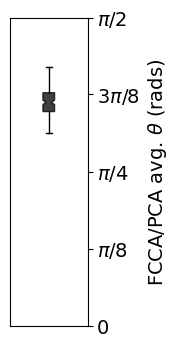

In [17]:
fig, ax = plt.subplots(figsize=(1, 4))

medianprops = {'linewidth':0}
bplot = ax.boxplot(np.mean(ss_angles, axis=-1).ravel(), patch_artist=True, medianprops=medianprops, notch=True, vert=True, showfliers=False)
ax.set_xticks([])
ax.set_ylabel('FCCA/PCA avg. ' + r'$\theta$ '+  '(rads)', fontsize=14)
ax.set_yticks([0, np.pi/8, np.pi/4, 3 * np.pi/8, np.pi/2])
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.set_yticklabels(['0', r'$\pi/8$', r'$\pi/4$', r'$3\pi/8$', r'$\pi/2$'], fontsize=14)

for patch in bplot['boxes']:
    patch.set_facecolor('k')
    patch.set_alpha(0.75)


#ax.set_title('Macaque M1', fontsize=16)
fig.savefig('/home/akumar/nse/neural_control/figs/loco_indy_merge/M1_ssa.pdf', bbox_inches='tight', pad_inches=0)

In [ ]:
# load the marginal subsapce angles and test for significance

In [4]:
with open('/mnt/Secondary/data/postprocessed/peanut_decoding_df.dat', 'rb') as f:
    peanut_df = pickle.load(f)

peanut_df = pd.DataFrame(peanut_df)

/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LinearRegression from version 0.24.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [5]:
dim = 6
ss_angles = np.zeros((8, 5, dim))

epochs = np.unique(peanut_df['epoch'].values)
folds = np.arange(5)
dimreduc_methods = ['PCA', 'LQGCAtrace']
KCA_dimreduc_args =  [{'T':3, 'causal_weights':(1, 0), 'n_init':5}, {'T':3, 'causal_weights':(0, 1), 'n_init':5}, {'T':3, 'causal_weights':(1, 1), 'n_init':5}]
LQGCA_dimreduc_args = [{'T':3, 'loss_type':'trace', 'n_init':5}, {'T':3, 'loss_type':'fro', 'n_init':5}, {'T':3, 'loss_type':'logdet', 'n_init':5},
                       {'T':3, 'loss_type':'additive', 'n_init':5}]

# Pick one
decoder_arg = peanut_df.iloc[0]['decoder_args']
df = apply_df_filters(peanut_df, decoder_args=decoder_arg)

for i, epoch in enumerate(epochs):
    for f, fold in enumerate(folds):
        dfpca = apply_df_filters(df, epoch=epoch, dimreduc_method='PCA', fold_idx=fold, dim=dim)
        dffcca = apply_df_filters(df, epoch=epoch, dimreduc_method='LQGCA', dimreduc_args=LQGCA_dimreduc_args[0], fold_idx=fold, dim=dim)

        assert(dfpca.shape[0] == 1)
        assert(dffcca.shape[0] == 1)
        
        ss_angles[i, f, :] = scipy.linalg.subspace_angles(dfpca.iloc[0]['coef'][:, 0:dim], dffcca.iloc[0]['coef'])

In [9]:
np.median(np.mean(ss_angles, axis=-1).ravel())

1.3664441026790626

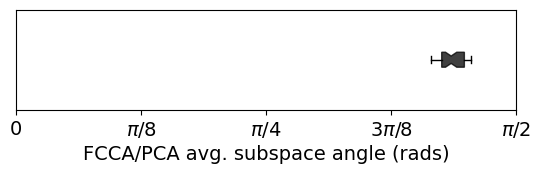

In [28]:
fig = plt.figure(figsize=(5, 6))
# rect1 = [0, 1./6., 1, 5./6.]
rect2 = [0, 0, 1, 1./6.]

# levels = [1e-6, 1e-1]

# nn_obj = nn_HPc
# n_obj = n_HPc

# ax = fig.add_axes(rect1)
# ax.set_aspect('equal')
# ax.tricontourf(nn_obj.triang, nn_obj.vals, levels=levels, colors=['k'], alpha=0.2)
# ax.scatter(np.real(np.linalg.eigvals(A_HPc)), np.imag(np.linalg.eigvals(A_HPc)), s=15, alpha=0.5, marker='o', edgecolor='k', color='r')

# epsilons = list(np.sort(levels))
# padepsilons = [epsilons[0]*0.9] + epsilons + [epsilons[-1]*1.1]
# X = []
# Y = []
# Z = []
# for epsilon in padepsilons:
#     paths = n_obj.contour_paths(epsilon)
#     for path in paths:
#         X += list(np.real(path.vertices[:-1]))
#         Y += list(np.imag(path.vertices[:-1]))
#         Z += [epsilon] * (len(path.vertices) - 1)
# ax.tricontour(X, Y, Z, levels=[1e-1], colors='k')


# # Add stability circle
# circle1 = plt.Circle((0, 0), 1, color='k', fill=False, linestyle='--')
# ax.add_patch(circle1)
# ax.set_ylabel('Im' + r'$(z)$', fontsize=14)
# ax.set_yticks([-1., -0.5, 0, 0.5, 1.])
# ax.set_xlabel('Re' + r'$(z)$', fontsize=14)
# ax.set_xticks([-1., -0.5, 0, 0.5, 1.])

# ax.set_xlim([-1.3, 1.3])
# ax.set_ylim([-1.3, 1.3])
# ax.xaxis.tick_top()
# ax.xaxis.set_label_position('top')

# ax.tick_params(axis='both', labelsize=14)
# #ax.set_title('Rat Hippocampus', fontsize=16)

ax_hist = fig.add_axes(rect2)
medianprops = {'linewidth':0}
bplot = ax_hist.boxplot(np.mean(ss_angles, axis=-1).ravel(), patch_artist=True, medianprops=medianprops, notch=True, vert=False, showfliers=False)

# ax_hist.hist(np.mean(ss_angles, axis=-1).ravel(), color='r', alpha=0.5, linewidth=1, edgecolor='k')
# ax_hist.set_xlim([0, np.pi/2])
# ax_hist.tick_params(axis='both', labelsize=14)
# ax_hist.set_ylabel('Count', fontsize=14)
ax_hist.set_yticks([])
ax_hist.set_xlabel('FCCA/PCA avg. subspace angle (rads)', fontsize=14)
ax_hist.set_xticks([0, np.pi/8, np.pi/4, 3 * np.pi/8, np.pi/2])
ax_hist.set_xticklabels(['0', r'$\pi/8$', r'$\pi/4$', r'$3\pi/8$', r'$\pi/2$'], fontsize=14)

for patch in bplot['boxes']:
    patch.set_facecolor('k')
    patch.set_alpha(0.75)

#fig.savefig('/home/akumar/nse/neural_control/figs/final/HPc_pseudospectra.pdf', bbox_inches='tight', pad_inches=0)

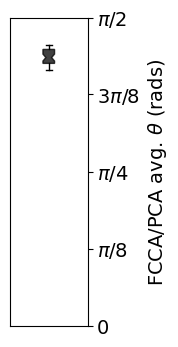

In [19]:
fig, ax = plt.subplots(figsize=(1, 4))

medianprops = {'linewidth':0}
bplot = ax.boxplot(np.mean(ss_angles, axis=-1).ravel(), patch_artist=True, medianprops=medianprops, notch=True, vert=True, showfliers=False)
ax.set_xticks([])
ax.set_ylabel('FCCA/PCA avg. ' + r'$\theta$ '+  '(rads)', fontsize=14)
ax.set_yticks([0, np.pi/8, np.pi/4, 3 * np.pi/8, np.pi/2])
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.set_yticklabels(['0', r'$\pi/8$', r'$\pi/4$', r'$3\pi/8$', r'$\pi/2$'], fontsize=14)

for patch in bplot['boxes']:
    patch.set_facecolor('k')
    patch.set_alpha(0.75)


#ax.set_title('Macaque M1', fontsize=16)
fig.savefig('/home/akumar/nse/neural_control/figs/loco_indy_merge/HPC_ssa.pdf', bbox_inches='tight', pad_inches=0)

In [20]:
with open('/mnt/Secondary/data/postprocessed/cv_dimreduc_df.dat', 'rb') as f:
    cv_df = pickle.load(f)
cv_df = pd.DataFrame(cv_df)
data_files = np.unique(cv_df['data_file'].values)

In [21]:
dim = 6
ss_angles = np.zeros((2, 5, dim))

folds = np.arange(5)
dimreduc_methods = ['PCA', 'LQGCAtrace']
LQGCA_dimreduc_args = [{'T':40, 'loss_type':'trace', 'n_init':5}]

for i, data_file in enumerate(data_files):
    for f, fold in enumerate(folds):
        dfpca = apply_df_filters(cv_df, dimreduc_method='PCA', fold_idx=fold, dim=dim, data_file=data_file)
        dffcca = apply_df_filters(cv_df, dimreduc_method='LQGCA', dimreduc_args=LQGCA_dimreduc_args[0], fold_idx=fold, dim=dim, data_file=data_file)

        assert(dfpca.shape[0] == 1)
        assert(dffcca.shape[0] == 1)
            
        ss_angles[i, f, :] = scipy.linalg.subspace_angles(dfpca.iloc[0]['coef'][:, 0:dim], dffcca.iloc[0]['coef'])

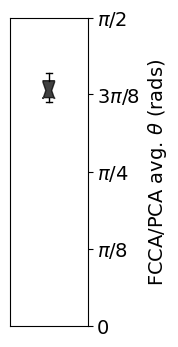

In [22]:
fig, ax = plt.subplots(figsize=(1, 4))

medianprops = {'linewidth':0}
bplot = ax.boxplot(np.mean(ss_angles, axis=-1).ravel(), patch_artist=True, medianprops=medianprops, notch=True, vert=True, showfliers=False)
ax.set_xticks([])
ax.set_ylabel('FCCA/PCA avg. ' + r'$\theta$ '+  '(rads)', fontsize=14)
ax.set_yticks([0, np.pi/8, np.pi/4, 3 * np.pi/8, np.pi/2])
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.set_yticklabels(['0', r'$\pi/8$', r'$\pi/4$', r'$3\pi/8$', r'$\pi/2$'], fontsize=14)

for patch in bplot['boxes']:
    patch.set_facecolor('k')
    patch.set_alpha(0.75)


#ax.set_title('Macaque M1', fontsize=16)
fig.savefig('/home/akumar/nse/neural_control/figs/loco_indy_merge/CV_ssa.pdf', bbox_inches='tight', pad_inches=0)

/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/pseudopy/normal.py:38: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  pseudospec = cascaded_union(circles)
/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/pseudopy/utils.py:40: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in obj:


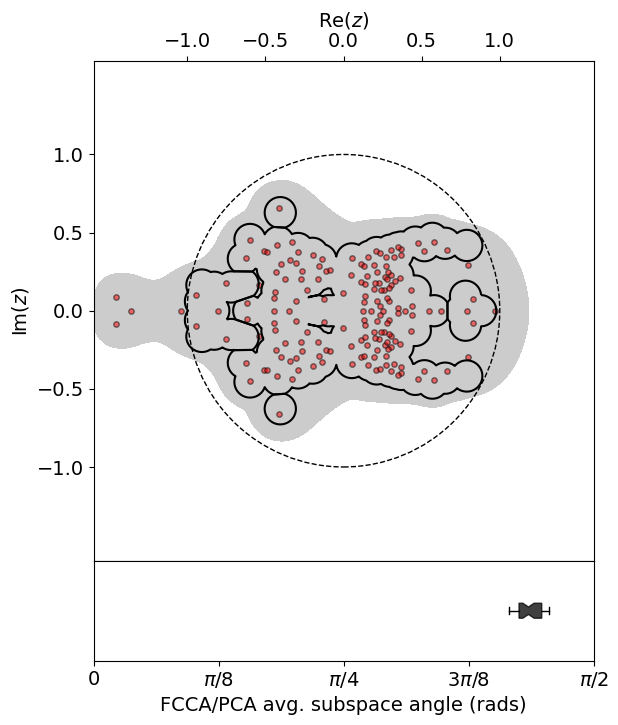

In [31]:
fig = plt.figure(figsize=(5, 6))
rect1 = [0, 1./6., 1, 5./6.]
rect2 = [0, 0, 1, 1./6.]

levels = [1e-6, 1e-1]
levels = [1e-6, 1e-1]

nn_obj = nn_CV
n_obj = n_CV

ax = fig.add_axes(rect1)
ax.set_aspect('equal')
ax.tricontourf(nn_obj.triang, nn_obj.vals, levels=levels, colors=['k'], alpha=0.2)
ax.scatter(np.real(np.linalg.eigvals(A_CV)), np.imag(np.linalg.eigvals(A_CV)), s=15, alpha=0.5, marker='o', edgecolor='k', color='r')

epsilons = list(np.sort(levels))
padepsilons = [epsilons[0]*0.99] + epsilons + [epsilons[-1]*1.01]
X = []
Y = []
Z = []
for epsilon in padepsilons:
    paths = n_obj.contour_paths(epsilon)
    for path in paths:
        X += list(np.real(path.vertices[:-1]))
        Y += list(np.imag(path.vertices[:-1]))
        Z += [epsilon] * (len(path.vertices) - 1)
ax.tricontour(X, Y, Z, levels=[1e-1], colors='k')


# Add stability circle
circle1 = plt.Circle((0, 0), 1, color='k', fill=False, linestyle='--')
ax.add_patch(circle1)
ax.set_ylabel('Im' + r'$(z)$', fontsize=14)
ax.set_yticks([-1., -0.5, 0, 0.5, 1.])
ax.set_xlabel('Re' + r'$(z)$', fontsize=14)
ax.set_xticks([-1., -0.5, 0, 0.5, 1.])

ax.set_xlim([-1.6, 1.6])
ax.set_ylim([-1.6, 1.6])
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')


ax.tick_params(axis='both', labelsize=14)
#ax.set_title('Human vSMC', fontsize=16)

ax_hist = fig.add_axes(rect2)
medianprops = {'linewidth':0}
bplot = ax_hist.boxplot(np.mean(ss_angles, axis=-1).ravel(), patch_artist=True, medianprops=medianprops, notch=True, vert=False, showfliers=False)

# ax_hist.hist(np.mean(ss_angles, axis=-1).ravel(), color='r', alpha=0.5, linewidth=1, edgecolor='k')
# ax_hist.set_xlim([0, np.pi/2])
# ax_hist.tick_params(axis='both', labelsize=14)
# ax_hist.set_ylabel('Count', fontsize=14)
ax_hist.set_yticks([])
ax_hist.set_xlabel('FCCA/PCA avg. subspace angle (rads)', fontsize=14)
ax_hist.set_xticks([0, np.pi/8, np.pi/4, 3 * np.pi/8, np.pi/2])
ax_hist.set_xticklabels(['0', r'$\pi/8$', r'$\pi/4$', r'$3\pi/8$', r'$\pi/2$'], fontsize=14)

for patch in bplot['boxes']:
    patch.set_facecolor('k')
    patch.set_alpha(0.75)


# fig.savefig('/home/akumar/nse/neural_control/figs/final/CV_pseudospectra.pdf', bbox_inches='tight', pad_inches=0)

In [87]:
# Is there a relationship between the angles between U and V and the magnitude of singular values? What about the QR decomposition?
U, S, Vh = np.linalg.svd(A_M1)
angles1 = np.zeros(S.size)
angles2 = np.zeros(S.size)
for i in range(S.size):
    angles1[i] = scipy.linalg.subspace_angles(U[:, i][:, np.newaxis], Vh.T[:, i][:, np.newaxis])
    if i == 0:
        angles2[i] = np.min(scipy.linalg.subspace_angles(U[:, 0][:, np.newaxis], Vh.T[:, 0][:, np.newaxis]))
    else:
        angles2[i] = np.min(scipy.linalg.subspace_angles(U[:, 0:i], Vh.T[:, 0:i]))

In [88]:
angles1

array([1.0803222 , 1.1961237 , 1.44164838, 1.28549876, 1.23885814,
       1.17095301, 1.40728471, 1.30826797, 1.5256939 , 1.25225824,
       1.52562916, 1.37905139, 1.50919516, 1.36528353, 1.37068865,
       1.41025124, 1.51346567, 1.52103537, 1.47701399, 1.46969492,
       1.40791917, 1.5385153 , 1.51673985, 1.56238261, 1.56213271,
       1.49408758, 1.43915994, 1.55781084, 1.46755573, 1.38404342,
       1.56362052, 1.45292742, 1.40991364, 1.45051758, 1.55014917,
       1.5598541 , 1.50149874, 1.54137504, 1.49120007, 1.51472167,
       1.50744349, 1.47350822, 1.55019885, 1.46697674, 1.56034179,
       1.55038762, 1.50371321, 1.56696093, 1.47843332, 1.4634027 ,
       1.47907368, 1.53873533, 1.49626319, 1.48507785, 1.51993142,
       1.5074086 , 1.52516031, 1.51233253, 1.43105764, 1.5418268 ,
       1.55648666, 1.55834714, 1.51184378, 1.55829104, 1.53159699,
       1.55746066, 1.47866534, 1.53549074, 1.45706516, 1.56830415,
       1.50442273, 1.47745087, 1.54211515, 1.52316031, 1.55056

In [89]:
angles2

array([1.0803222 , 1.0803222 , 1.07852823, 1.05077927, 1.04920866,
       1.04906975, 1.02236827, 1.00837042, 1.00252826, 0.99271697,
       0.97770523, 0.96486517, 0.92945007, 0.92931533, 0.9173389 ,
       0.88904698, 0.86215544, 0.86015138, 0.83775342, 0.83699998,
       0.8341324 , 0.81824206, 0.81554332, 0.80549852, 0.784136  ,
       0.77677496, 0.76088149, 0.75373427, 0.75043006, 0.75009816,
       0.74175181, 0.73675496, 0.73341822, 0.72825172, 0.71927599,
       0.71460018, 0.70794752, 0.70532722, 0.69782524, 0.68870121,
       0.68788386, 0.68734936, 0.68447283, 0.67689507, 0.66940785,
       0.65415143, 0.65131946, 0.6340602 , 0.63362437, 0.63161027,
       0.62929441, 0.62868704, 0.62097791, 0.61607985, 0.61567089,
       0.60630922, 0.60408415, 0.59826158, 0.58735593, 0.58192023,
       0.57406065, 0.57257364, 0.57227189, 0.56744604, 0.56702636,
       0.56491216, 0.56453916, 0.56394589, 0.56262685, 0.55740897,
       0.55659828, 0.54986835, 0.54945916, 0.54827994, 0.54637

In [90]:
# Distribution of eigenvector condition numbers
eig,L,R = scipy.linalg.eig(A_M1, left=True)

In [102]:
cond_numbers = np.zeros(eig.size)
for i in range(eig.size):
    cond_numbers[i] = np.abs(np.conjugate(L[:, i]) @ R[:, i])
#    cond_numbers[i] = L[:, i] @ np.linalg.norm(np.conjugate(L[:, i]) * R[:,i] @ np.conjugate(R[:, i])

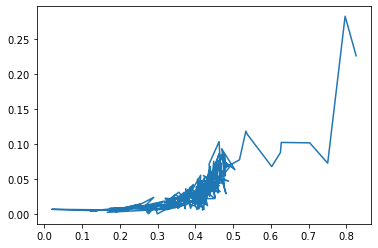

In [103]:
plt.plot(rnp.abs(eig), cond_numbers)

In [104]:
# Angle between subspaces and call it a day

### Angle between subspaces

In [4]:
with open('/home/akumar/nse/neural_control/data/sabes_decoding_df.dat', 'rb') as f:
    sabes_df = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: '/home/akumar/nse/neural_control/data/sabes_decoding_df.dat'

In [118]:
dim = 2
ss_angles = np.zeros((28, 5, dim))
data_files = np.unique(sabes_df['data_file'].values)
folds = np.arange(5)
dimreduc_methods = dimreduc_methods = ['PCA', 'LQGCAtrace']
KCA_dimreduc_args =  [{'T':3, 'causal_weights':(1, 0), 'n_init':5}, {'T':3, 'causal_weights':(0, 1), 'n_init':5}, {'T':3, 'causal_weights':(1, 1), 'n_init':5}]
LQGCA_dimreduc_args = [{'T':3, 'loss_type':'trace', 'n_init':5}, {'T':3, 'loss_type':'fro', 'n_init':5}, {'T':3, 'loss_type':'logdet', 'n_init':5},
                       {'T':3, 'loss_type':'additive', 'n_init':5}]

dimvals = np.unique(sabes_df['dim'].values)

# Pick one
decoder_arg = sabes_df.iloc[0]['decoder_args']
df = apply_df_filters(sabes_df, decoder_args=decoder_arg)
for i, data_file in enumerate(data_files):
    for f, fold in enumerate(folds):

        dfpca = apply_df_filters(df, data_file=data_file, dimreduc_method='PCA', fold_idx=fold, dim=dim)
        dffcca = apply_df_filters(df, data_file=data_file, dimreduc_method='LQGCA', dimreduc_args=LQGCA_dimreduc_args[0], fold_idx=fold, dim=dim)

        assert(dfpca.shape[0] == 1)
        assert(dffcca.shape[0] == 1)
        
        ss_angles[i, f, :] = scipy.linalg.subspace_angles(dfpca.iloc[0]['coef'][:, 0:dim], dffcca.iloc[0]['coef'])

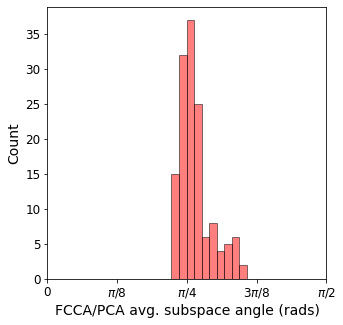

In [252]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.hist(np.mean(ss_angles, axis=-1).ravel(), color='r', alpha=0.5, linewidth=1, edgecolor='k')
ax.set_xlim([0, np.pi/2])
ax.tick_params(axis='both', labelsize=12)
ax.set_ylabel('Count', fontsize=14)
ax.set_xlabel('FCCA/PCA avg. subspace angle (rads)', fontsize=14)
ax.set_xticks([0, np.pi/8, np.pi/4, 3 * np.pi/8, np.pi/2])
ax.set_xticklabels(['0', r'$\pi/8$', r'$\pi/4$', r'$3\pi/8$', r'$\pi/2$'])
fig.savefig('/home/akumar/nse/neural_control/figs/final/m1_ssangles.pdf', bbox_inches='tight', pad_inches=0)

In [143]:
with open('/home/akumar/nse/neural_control/data/peanut_decoding_df.dat', 'rb') as f:
    peanut_df = pickle.load(f)

In [254]:
dim = 2
ss_angles = np.zeros((8, 5, dim))

epochs = np.unique(peanut_df['epoch'].values)
folds = np.arange(5)
dimreduc_methods = ['PCA', 'LQGCAtrace']
KCA_dimreduc_args =  [{'T':3, 'causal_weights':(1, 0), 'n_init':5}, {'T':3, 'causal_weights':(0, 1), 'n_init':5}, {'T':3, 'causal_weights':(1, 1), 'n_init':5}]
LQGCA_dimreduc_args = [{'T':3, 'loss_type':'trace', 'n_init':5}, {'T':3, 'loss_type':'fro', 'n_init':5}, {'T':3, 'loss_type':'logdet', 'n_init':5},
                       {'T':3, 'loss_type':'additive', 'n_init':5}]

# Pick one
decoder_arg = peanut_df.iloc[0]['decoder_args']
df = apply_df_filters(peanut_df, decoder_args=decoder_arg)

for i, epoch in enumerate(epochs):
    for f, fold in enumerate(folds):
        dfpca = apply_df_filters(df, epoch=epoch, dimreduc_method='PCA', fold_idx=fold, dim=dim)
        dffcca = apply_df_filters(df, epoch=epoch, dimreduc_method='LQGCA', dimreduc_args=LQGCA_dimreduc_args[0], fold_idx=fold, dim=dim)

        assert(dfpca.shape[0] == 1)
        assert(dffcca.shape[0] == 1)
        
        ss_angles[i, f, :] = scipy.linalg.subspace_angles(dfpca.iloc[0]['coef'][:, 0:dim], dffcca.iloc[0]['coef'])

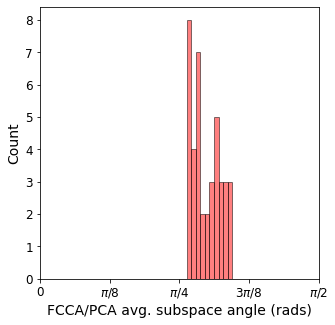

In [255]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.hist(np.mean(ss_angles, axis=-1).ravel(), color='r', alpha=0.5, linewidth=1, edgecolor='k')
ax.set_xlim([0, np.pi/2])
ax.tick_params(axis='both', labelsize=12)
ax.set_ylabel('Count', fontsize=14)
ax.set_xlabel('FCCA/PCA avg. subspace angle (rads)', fontsize=14)
ax.set_xticks([0, np.pi/8, np.pi/4, 3 * np.pi/8, np.pi/2])
ax.set_xticklabels(['0', r'$\pi/8$', r'$\pi/4$', r'$3\pi/8$', r'$\pi/2$'])
fig.savefig('/home/akumar/nse/neural_control/figs/final/hpc_ssangles.pdf', bbox_inches='tight', pad_inches=0)

In [149]:
with open('/home/akumar/nse/neural_control/data/cv_dimreduc_both.dat', 'rb') as f:
    cv_df = pickle.load(f)

In [150]:
cv_df = pd.DataFrame(cv_df)

In [151]:
data_files = np.unique(cv_df['data_file'].values)

In [258]:
dim = 2
ss_angles = np.zeros((2, 5, dim))

folds = np.arange(5)
dimreduc_methods = ['PCA', 'LQGCAtrace']
LQGCA_dimreduc_args = [{'T':40, 'loss_type':'trace', 'n_init':5}]

for i, data_file in enumerate(data_files):
    for f, fold in enumerate(folds):
        dfpca = apply_df_filters(cv_df, dimreduc_method='PCA', fold_idx=fold, dim=dim, data_file=data_file)
        dffcca = apply_df_filters(cv_df, dimreduc_method='LQGCA', dimreduc_args=LQGCA_dimreduc_args[0], fold_idx=fold, dim=dim, data_file=data_file)

        assert(dfpca.shape[0] == 1)
        assert(dffcca.shape[0] == 1)
            
        ss_angles[i, f, :] = scipy.linalg.subspace_angles(dfpca.iloc[0]['coef'][:, 0:dim], dffcca.iloc[0]['coef'])

In [239]:
# Loading correlation

In [240]:
from utils import calc_loadings

In [242]:
dim = 2
lc = np.zeros((2, 5))

folds = np.arange(5)
dimreduc_methods = ['PCA', 'LQGCAtrace']
LQGCA_dimreduc_args = [{'T':40, 'loss_type':'trace', 'n_init':5}]

for i, data_file in enumerate(data_files):
    for f, fold in enumerate(folds):
        dfpca = apply_df_filters(cv_df, dimreduc_method='PCA', fold_idx=fold, dim=dim, data_file=data_file)
        dffcca = apply_df_filters(cv_df, dimreduc_method='LQGCA', dimreduc_args=LQGCA_dimreduc_args[0], fold_idx=fold, dim=dim, data_file=data_file)

        l1 = calc_loadings(dfpca.iloc[0]['coef'][:, 0:dim])
        l2 = calc_loadings(dffcca.iloc[0]['coef'])
        lc[i, f] = scipy.stats.spearmanr(l1, l2)[0]

In [244]:
data_files

array(['/mnt/Secondary/data/cv/EC2_hg.h5',
       '/mnt/Secondary/data/cv/EC9_hg.h5'], dtype=object)

In [243]:
lc

array([[0.8401434 , 0.86420114, 0.82448229, 0.86891835, 0.87256003],
       [0.60571074, 0.59498729, 0.58168414, 0.56185587, 0.58345452]])

In [222]:
%matplotlib inline

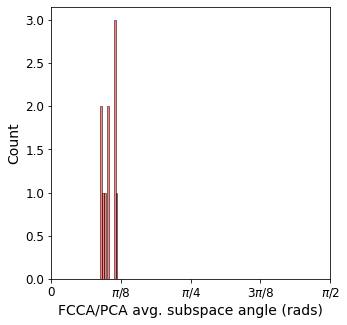

In [259]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.hist(np.mean(ss_angles, axis=-1).ravel(), color='r', alpha=0.5, linewidth=1, edgecolor='k')
ax.set_xlim([0, np.pi/2])
ax.tick_params(axis='both', labelsize=12)
ax.set_ylabel('Count', fontsize=14)
ax.set_xlabel('FCCA/PCA avg. subspace angle (rads)', fontsize=14)
ax.set_xticks([0, np.pi/8, np.pi/4, 3 * np.pi/8, np.pi/2])
ax.set_xticklabels(['0', r'$\pi/8$', r'$\pi/4$', r'$3\pi/8$', r'$\pi/2$'])
fig.savefig('/home/akumar/nse/neural_control/figs/final/cv_ssangles.pdf', bbox_inches='tight', pad_inches=0)

### Spike rasters/Traces

In [4]:
from segmentation import reach_segment_sabes

In [5]:
start_times = {'indy_20160426_01': 0,
               'indy_20160622_01':1700,
               'indy_20160624_03': 500,
               'indy_20160627_01': 0,
               'indy_20160630_01': 0,
               'indy_20160915_01': 0,
               'indy_20160921_01': 0,
               'indy_20160930_02': 0,
               'indy_20160930_05': 300,
               'indy_20161005_06': 0,
               'indy_20161006_02': 350,
               'indy_20161007_02': 950,
               'indy_20161011_03': 0,
               'indy_20161013_03': 0,
               'indy_20161014_04': 0,
               'indy_20161017_02': 0,
               'indy_20161024_03': 0,
               'indy_20161025_04': 0,
               'indy_20161026_03': 0,
               'indy_20161027_03': 500,
               'indy_20161206_02': 5500,
               'indy_20161207_02': 0,
               'indy_20161212_02': 0,
               'indy_20161220_02': 0,
               'indy_20170123_02': 0,
               'indy_20170124_01': 0,
               'indy_20170127_03': 0,
               'indy_20170131_02': 0,
               }

In [6]:
# plot the spike raster after a reach
with open('/mnt/Secondary/data/postprocessed/sabes_decoding_df.dat', 'rb') as f:
    sabes_df = pickle.load(f)

/home/akumar/anaconda3/envs/ncontrol/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator LinearRegression from version 0.24.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [7]:
data_path = '/mnt/Secondary/data/sabes'
data_files = np.unique(sabes_df['data_file'].values)

In [8]:
dat = load_sabes('%s/%s' % (data_path, data_files[3]), boxcox=None, high_pass=False, bin_width=10, filter_fn='gaussian', filter_kwargs={'sigma':1.5})
#dat = load_sabes('%s/%s' % (data_path, data_files[3]), boxcox=None, high_pass=False, bin_width=5)
dat_segment = reach_segment_sabes(dat, start_time=start_times[data_files[3].split('.mat')[0]])

T = 100
t = np.array([t_[1] - t_[0] for t_ in dat_segment['transition_times']])
valid_transitions = np.arange(t.size)[t >= T]

x_ = np.array([dat['spike_rates'][0, dat_segment['transition_times'][idx][0]:dat_segment['transition_times'][idx][0] + T] 
            for idx in valid_transitions])

Reminder that start times depend on the bin size


/home/akumar/nse/neural_control/notebooks/final/../../segmentation.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  m = straight[1]/straight[0]


/tmp/ipykernel_10651/393451303.py:38: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "pad_inhces" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig('/home/akumar/nse/neural_control/figs/final/spike_raster.pdf', bbox_inches='tight', pad_inhces=0)


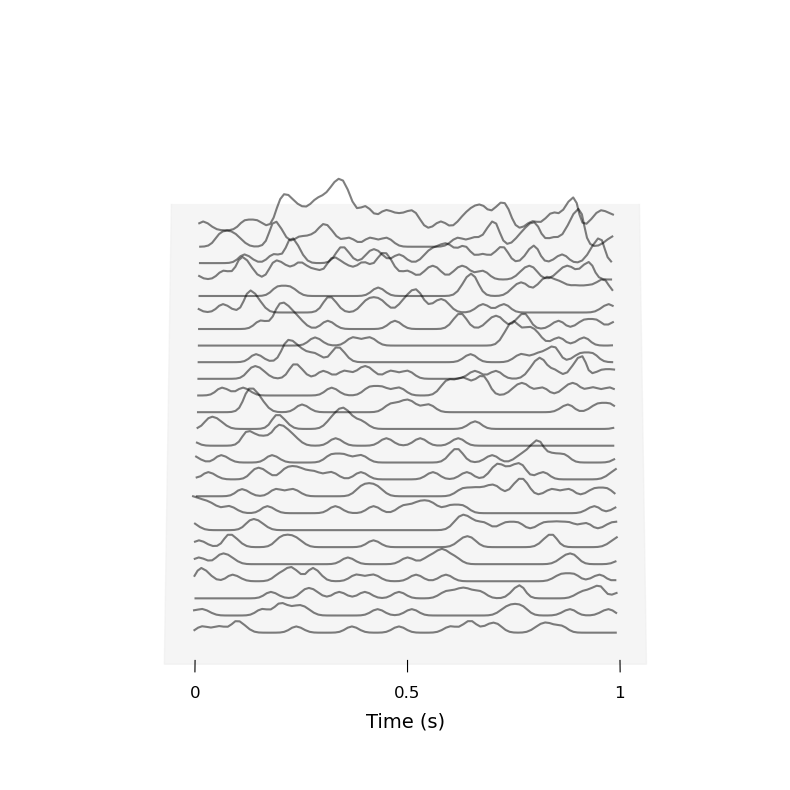

In [10]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')

idx = 3
# sort by variancec
var = np.var(x_[idx], axis=0)
#order = np.argsort(np.max(x_[idx], axis=0))
#order = np.argsort(np.mean(x_[idx], axis=0))
order = np.argsort(var)[::-1]
ax.view_init(elev=75, azim=0)

# Transparent spines
ax.grid(False)

ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))

# Transparent panes
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

for j, i in enumerate(order[0:25]):
    xx = x_[idx, :, i]
    # xx[xx <= -1] = np.nan
    ax.plot((2*j) * np.ones(x_.shape[1]), np.arange(x_.shape[1]), xx, 'k', alpha=0.5)
ax.set_zlim([0, 3])
ax.set_zticks([])
ax.set_xticks([])
#ax.set_xlabel('Neurons')
ax.set_yticks([0, 50, 100])
ax.set_yticklabels([0, 0.5, 1], fontsize=12)
#ax.tick_params(axis='y', labelize=14)
#ax.set_ylabel('Time (s)')
# fig, ax = lt.subplots(1, 1, figsize=(5, 5))
# ax.pcolor(x_[0].T, cmap='Greys')
ax.set_ylabel('Time (s)', fontsize=14, labelpad=10)
fig.savefig('/home/akumar/nse/neural_control/figs/final/spike_raster.pdf', bbox_inches='tight', pad_inhces=0)

[Text(0, 0, '0'), Text(100, 0, '0.5'), Text(200, 0, '1'), Text(300, 0, '1.5')]

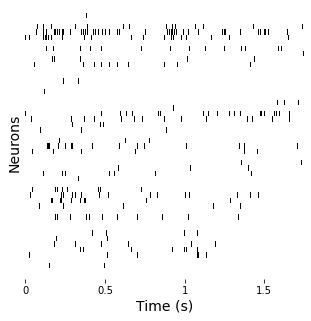

In [165]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.pcolor(x_[8, :, 0:50].T, cmap='Greys', vmin=0, vmax=1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_yticks([])
ax.set_ylabel('Neurons', fontsize=14)
ax.set_xlabel('Time (s)', fontsize=14)
ax.set_xticks([0, 100, 200, 300])
ax.set_xticklabels([0, 0.5, 1, 1.5])

In [8]:
from loaders import segment_peanut

In [9]:
fpath = '/mnt/Secondary/data/peanut/data_dict_peanut_day14.obj'
lpath = '/mnt/Secondary/data/peanut/linearization_dict_peanut_day14.obj'

In [69]:
# Peanut
dat = load_peanut(fpath, 2, spike_threshold=100, bin_width=10, speed_threshold=0, filter_fn='gaussian', filter_kwargs={'sigma':1.5})
transitions1, transitions2, nodes, endpoints = segment_peanut(dat, lpath, 2, return_maze_points=True)

/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:41: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "pad_inhces" which is no longer supported as of 3.3 and will become an error two minor releases later


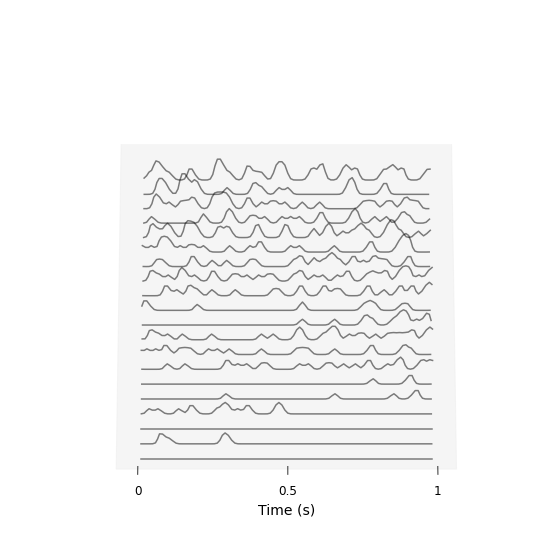

In [75]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')

x_ = dat['spike_rates'][transitions1[2], :]

# sort by variancec
var = np.var(x_, axis=0)
#order = np.argsort(np.max(x_[idx], axis=0))
#order = np.argsort(np.mean(x_[idx], axis=0))
order = np.argsort(var)[::-1]
#order = np.random.permutation(np.arange(x_.shape[1]))
ax.view_init(elev=75, azim=0)

# Transparent spines
ax.grid(False)

ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))

# Transparent panes
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

x_ = x_[0:100]

for j, i in enumerate(order[0:20]):
    # xx[xx <= -1] = np.nan
    ax.plot((2*j) * np.ones(x_.shape[0]), np.arange(x_.shape[0]), x_[:, i], 'k', alpha=0.5)
ax.set_zlim([0, 8])
ax.set_zticks([])
ax.set_xticks([])
#ax.set_xlabel('Neurons')
ax.set_yticks([0, 50, 100])
ax.set_yticklabels([0, 0.5, 1], fontsize=12)
#ax.tick_params(axis='y', labelize=14)
ax.set_ylabel('Time (s)', fontsize=14, labelpad=10)
# ax.set_xlabel('Neurons', fontsize=14, labelpad=-300)
# fig, ax = lt.subplots(1, 1, figsize=(5, 5))
# ax.pcolor(x_[0].T, cmap='Greys')
fig.savefig('/home/akumar/nse/neural_control/figs/final/spike_raster_peanut.pdf', bbox_inches='tight', pad_inhces=0)

In [102]:
# CV dataset
dat = load_cv('/mnt/Secondary/data/cv/EC2_hg.h5')

In [103]:
dat['spike_rates'].shape

(2566, 258, 86)

/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:41: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "pad_inhces" which is no longer supported as of 3.3 and will become an error two minor releases later


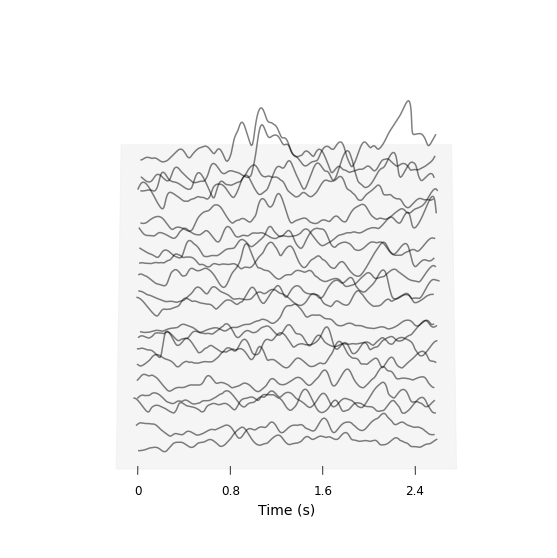

In [106]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')

x_ = dat['spike_rates'][0]

# sort by variancec
var = np.var(x_, axis=0)
#order = np.argsort(np.max(x_[idx], axis=0))
#order = np.argsort(np.mean(x_[idx], axis=0))
order = np.argsort(var)[::-1]
#order = np.random.permutation(np.arange(x_.shape[1]))
ax.view_init(elev=75, azim=0)

# Transparent spines
ax.grid(False)

ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))

# Transparent panes
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

#x_ = x_[0:100]

for j, i in enumerate(order[0:20]):
    # xx[xx <= -1] = np.nan
    ax.plot((2*j) * np.ones(x_.shape[0]), np.arange(x_.shape[0]), x_[:, i], 'k', alpha=0.5)
ax.set_zlim([0, 50])
ax.set_zticks([])
ax.set_xticks([])
#ax.set_xlabel('Neurons')
ax.set_yticks([0, 80, 160, 240])
ax.set_yticklabels([0, 0.8, 1.6, 2.4], fontsize=12)
#ax.tick_params(axis='y', labelize=14)
ax.set_ylabel('Time (s)', fontsize=14, labelpad=10)
# ax.set_xlabel('Neurons', fontsize=14, labelpad=-300)
# fig, ax = lt.subplots(1, 1, figsize=(5, 5))
# ax.pcolor(x_[0].T, cmap='Greys')
fig.savefig('/home/akumar/nse/neural_control/figs/final/spike_raster_cv.pdf', bbox_inches='tight', pad_inhces=0)